In [60]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

device = ('cuda' if torch.cuda.is_available() else 'cpu')
device_name = torch.cuda.get_device_name(torch.cuda.current_device())

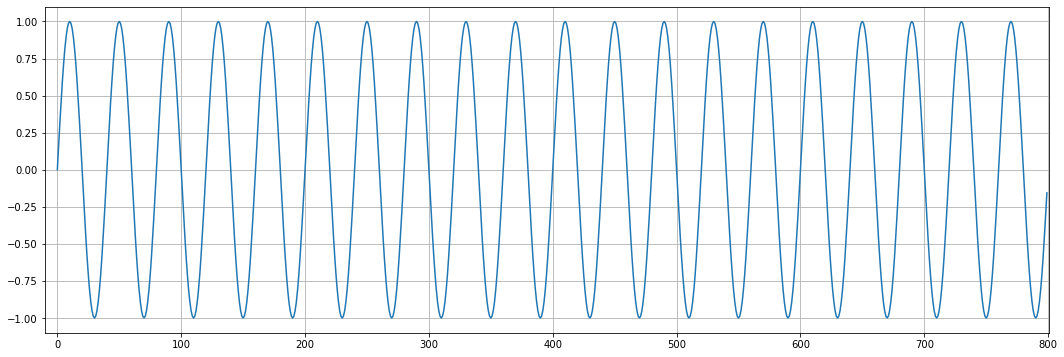

In [61]:
x = torch.linspace(0, 799, 800)
y = torch.sin(x*2*3.1416/40)

plt.figure(figsize=(18,6))
plt.xlim(-10,801)
plt.grid(True)
plt.plot(y.numpy())

In [62]:
print(y[0:40], )

tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01])


In [63]:
test_size = 40
learning_rate = 0.01
epochs = 5
future = 40
window_size = 40

train_set = y[:-test_size]
test_set = y[-test_size:]

In [64]:
def input_data(seq, ws):
    output_data = []
    L = len(seq)
    for i in range(L-ws):
        window = seq[i:i+ws]
        label = seq[i+ws:i+ws+1]
        output_data.append((window, label))
    return output_data

In [65]:
train_data = input_data(train_set, window_size)
print(len(train_data))
print(train_data)

720
[(tensor([ 0.0000e+00,  1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,
         7.0711e-01,  8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,
         1.0000e+00,  9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,
         7.0710e-01,  5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01,
        -7.2400e-06, -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01,
        -7.0711e-01, -8.0902e-01, -8.9101e-01, -9.5106e-01, -9.8769e-01,
        -1.0000e+00, -9.8769e-01, -9.5105e-01, -8.9100e-01, -8.0901e-01,
        -7.0710e-01, -5.8777e-01, -4.5398e-01, -3.0900e-01, -1.5642e-01]), tensor([1.4480e-05])), (tensor([ 1.5643e-01,  3.0902e-01,  4.5399e-01,  5.8779e-01,  7.0711e-01,
         8.0902e-01,  8.9101e-01,  9.5106e-01,  9.8769e-01,  1.0000e+00,
         9.8769e-01,  9.5106e-01,  8.9100e-01,  8.0901e-01,  7.0710e-01,
         5.8778e-01,  4.5398e-01,  3.0901e-01,  1.5643e-01, -7.2400e-06,
        -1.5644e-01, -3.0902e-01, -4.5400e-01, -5.8779e-01, -7.0711e-01,
        -8.0902e-01

In [66]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        self.hidden_states = (torch.zeros(1,1,hidden_size).to(device), torch.zeros(1,1,hidden_size).to(device)) # (H, C)

    def forward(self, seq):
        lstm_out, self.hidden_states = self.lstm(seq.view(len(seq), 1, -1), self.hidden_states)
        pred = self.linear(lstm_out.view(len(seq), -1))
        return pred[-1] # [1,2,3] [4] ---> [1,2,3,4 (o/p is like this) but we need o/p like this 4]

In [67]:
model = LSTM().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [68]:
model

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

In [69]:
total = 0
for p in model.parameters():
    total += p.numel()
    print(p.numel())
print('Total:', total)

200
10000
200
200
50
1
Total: 10651


Epoch: 0 Train Loss: 0.08678057789802551
Epoch: 0 Test Loss: 0.6086689233779907


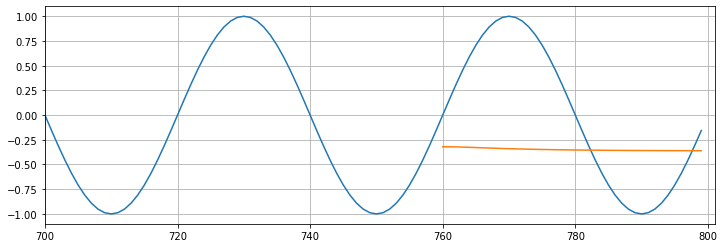

Epoch: 1 Train Loss: 0.05466553196310997
Epoch: 1 Test Loss: 0.5449568033218384


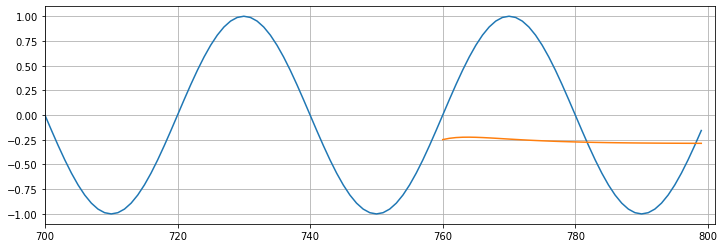

Epoch: 2 Train Loss: 0.022420652210712433
Epoch: 2 Test Loss: 0.420016348361969


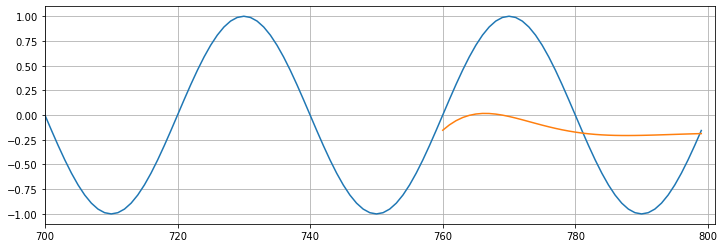

Epoch: 3 Train Loss: 0.0036883132997900248
Epoch: 3 Test Loss: 0.11442916095256805


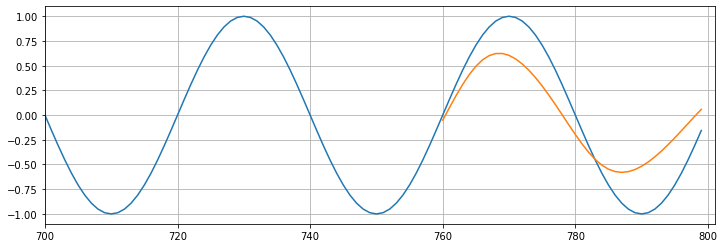

Epoch: 4 Train Loss: 0.0007609428721480072
Epoch: 4 Test Loss: 0.007254449184983969


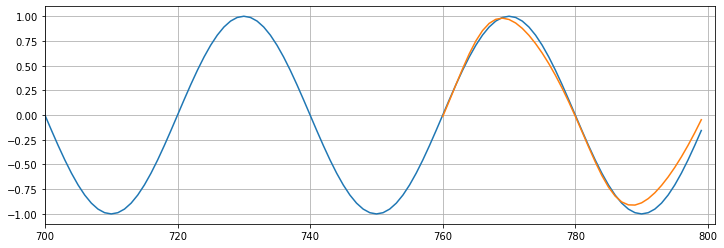

In [70]:
for epoch in range(epochs):
    loss = 0
    for seq, y_train in train_data:
        seq = seq.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()
        model.hidden_states = (torch.zeros(1,1,model.hidden_size).to(device), torch.zeros(1,1,model.hidden_size).to(device))
        y_pred = model(seq)

        loss =  criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()

    print(f"Epoch: {epoch} Train Loss: {loss.item()}")

    preds = train_set[-window_size:].tolist()

    for f in range(future):
        seq = torch.FloatTensor(preds[-window_size:])
        seq = seq.to(device)
        with torch.no_grad():
            model.hidden_states = (torch.zeros(1,1,model.hidden_size).to(device), torch.zeros(1,1,model.hidden_size).to(device))
            preds.append(model(seq).item())

    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f"Epoch: {epoch} Test Loss: {loss.item()}")

    plt.figure(figsize=(12,4))
    plt.xlim(700, 801)
    plt.grid(True)
    plt.plot(y.numpy())
    plt.plot(range(760,800), preds[-window_size:])
    plt.show()

In [71]:
preds = y[-window_size:].tolist()

for i in range(future):
    seq = torch.FloatTensor(preds[-window_size:]).to(device)

    with torch.no_grad():
        model.hidden = (torch.zeros(1,1,model.hidden_size).to(device), torch.zeros(1,1,model.hidden_size).to(device))

        preds.append(model(seq).item())

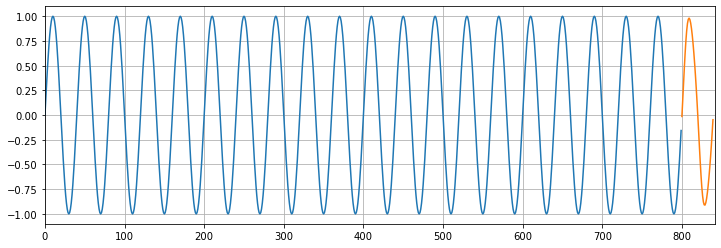

In [72]:
plt.figure(figsize=(12,4))
plt.xlim(0, 841)
plt.grid(True)
plt.plot(y.numpy())
plt.plot(range(800, 800+future), preds[window_size:])
plt.show()